In [1]:
EXPERIMENT = '05-15'
N_SPLITS = 5
SEED = 1
CLIP_UPPER_RATE = 1.5
CLIP_LOWER_RATE = 1.0
Y_THRESHOLD = 200

In [2]:
from collections import defaultdict
import configparser
from functools import partial
from itertools import chain
import json
import logging
import os
import pickle
import re
import sys
import time

SINCE = time.time()

from catboost import CatBoostClassifier
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearnex import patch_sklearn

config = configparser.ConfigParser()
INI_FILEPATH = os.path.join(os.path.expanduser('~'), 'aiquest2021-assesment', 'config.ini')
config.read(INI_FILEPATH)
if config['FOLDER']['SCRIPTS'] not in sys.path:
    sys.path.append(config['FOLDER']['SCRIPTS'])
from logging_util import get_logger, timer
from feature_engineering import make_or_load_features
from text_feature_extraction import make_or_load_vector

In [3]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
output_dir = os.path.join(config['FOLDER']['EXPERIMENTS'], EXPERIMENT)
os.makedirs(output_dir)

In [5]:
logger = get_logger(__name__, os.path.join(output_dir, 'log.log'))

# Loading

In [6]:
with timer('Load dataset', logger):
    train = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'train.csv'))
    test = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'test.csv'))
    sample_submit = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'sample_submit.csv'))

# Feature engineering

In [7]:
train_path = os.path.join(config['FOLDER']['FEATURES'], 'train_features.csv')
test_path = os.path.join(config['FOLDER']['FEATURES'], 'test_features.csv')

In [8]:
X, X_test = make_or_load_features(train, test, train_path, test_path, logger)

In [9]:
X

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,1.0,4.0,0,0,1,1,...,0,0,0,1,2016.0,7.0,2016.0,7.0,2016.0,7.0
1,1,2,1.0,0,1.0,1.0,1,1,1,1,...,1,1,0,0,2016.0,9.0,2015.0,12.0,2017.0,3.0
2,2,2,2.0,0,1.0,1.0,1,2,1,1,...,2,2,1,0,2016.0,6.0,2016.0,5.0,2017.0,8.0
3,3,2,1.0,0,1.0,1.0,1,3,1,1,...,0,3,0,1,2014.0,3.0,2012.0,6.0,2017.0,9.0
4,4,2,1.0,0,1.0,1.0,1,2,1,1,...,2,4,0,0,2015.0,8.0,2015.0,3.0,2017.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55578,55578,4,1.5,0,1.0,1.0,1,2,1,1,...,2,95,0,0,2013.0,2.0,2013.0,1.0,2017.0,9.0
55579,55579,2,1.0,0,1.0,1.0,2,4,0,1,...,3,181,0,0,2015.0,11.0,2015.0,1.0,2016.0,10.0
55580,55580,2,1.0,0,1.0,1.0,0,3,1,1,...,0,33,0,0,2016.0,3.0,2016.0,2.0,2017.0,4.0
55581,55581,1,1.5,0,1.0,1.0,2,0,1,1,...,0,251,0,0,2016.0,10.0,2016.0,4.0,2017.0,4.0


In [10]:
X_test

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,2.0,2.0,1,5,1,1,...,4,88,0,0,2017.0,1.0,2016.0,8.0,2017.0,9.0
1,1,3,1.0,0,1.0,1.0,2,0,1,1,...,0,16,0,0,2016.0,8.0,2014.0,9.0,2017.0,5.0
2,2,2,1.0,0,0.0,1.0,0,2,0,1,...,2,90,0,0,NaN,NaN,2012.0,10.0,NaN,NaN
3,3,4,1.0,0,1.0,2.0,1,2,0,1,...,2,44,0,0,NaN,NaN,2013.0,1.0,NaN,NaN
4,4,3,1.5,0,1.0,2.0,1,0,1,1,...,0,129,0,0,2015.0,8.0,2014.0,12.0,2016.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,18523,4,1.0,0,2.0,2.0,1,2,1,1,...,2,109,0,0,NaN,NaN,2009.0,11.0,NaN,NaN
18524,18524,2,1.0,0,2.0,1.0,0,4,0,1,...,3,22,0,1,2017.0,1.0,2017.0,1.0,2017.0,4.0
18525,18525,5,1.5,0,2.0,2.0,0,4,1,1,...,3,181,0,0,NaN,NaN,2014.0,9.0,NaN,NaN
18526,18526,2,1.0,0,1.0,2.0,1,2,1,1,...,2,158,0,0,2016.0,4.0,2014.0,3.0,2017.0,5.0


In [11]:
X.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]
X_test.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]

In [12]:
# Clustering
area_features = ['latitude', 'longitude']

# Onehot encoding
categorical_features = ['cancellation_policy', 'bed_type', 'city', 'neighbourhood', 'property_type',
                        'room_type', 'zipcode5', 'zipcode_1st_digit']

# They do not need to be encoded
int_flag_features = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified',
                     'instant_bookable', 'has_thumbnail', 'zipcode_imputed']

# Already one-hot style
amenity_onehot_features = [c for c in X.columns if c.startswith('has_') and c.endswith('_amenity')]

discrete_features = categorical_features + int_flag_features + amenity_onehot_features

# Scaling, transformation
continuous_features = [
    c for c in X.columns
    if c not in discrete_features + area_features + ['id', 'y']
]

In [13]:
%%time
# Reduce dimension & whitening
## training
decomposer = PCA(n_components=0.8, random_state=SEED, whiten=True).fit(X[amenity_onehot_features])
X_amenity_components = decomposer.transform(X[amenity_onehot_features])
amenity_components_columns = [f'amenity_x{i + 1}' for i in range(decomposer.n_components_)]
X_amenity_components = pd.DataFrame(data=X_amenity_components,
                                    columns=amenity_components_columns)
X = pd.concat([X, X_amenity_components], axis=1)
# X.drop(columns=amenity_onehot_features, inplace=True)
X_test_amenity_components = decomposer.transform(X_test[amenity_onehot_features])
X_test_amenity_components = pd.DataFrame(data=X_test_amenity_components,
                                         columns=amenity_components_columns)
X_test = pd.concat([X_test, X_test_amenity_components], axis=1)
# X_test.drop(columns=amenity_onehot_features, inplace=True)

Wall time: 537 ms


In [14]:
f = lambda s1, s2: ' '.join([s1, s2])
train['name+description'] = np.vectorize(f)(train['name'], train['description'])
test['name+description'] = np.vectorize(f)(test['name'], test['description'])

In [15]:
%%time
vec_train, vec_test = make_or_load_vector(train=train,
                                          test=test,
                                          feature_dir=config['FOLDER']['FEATURES'],
                                          logger=logger,
                                          text_column='name+description',
                                          embedder='lda_count',
                                          overwrite=True,
                                          random_state=85)

Wall time: 4min 39s


In [16]:
%%time
vec_columns = vec_train.columns.tolist()

Wall time: 0 ns


In [17]:
%%time
X = pd.concat([X, vec_train], axis=1)
X_test = pd.concat([X_test, vec_test], axis=1)
X.shape, X_test.shape

Wall time: 62.5 ms


((55583, 285), (18528, 285))

In [18]:
passthrough_features = amenity_onehot_features \
                     + amenity_components_columns \
                     + int_flag_features \
                     + area_features \
                     + vec_columns

In [19]:
def get_classifier(continuous_features, discrete_features, passthrough_features, random_state):
    continuous_preprocessor = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    )
    categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical', categorical_preprocessor, continuous_features),
            ('continuous', continuous_preprocessor, discrete_features),
            ('others', 'passthrough', passthrough_features)
        ],
    )
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('decomposer', TruncatedSVD(n_components=100, random_state=random_state)),
            ('classifier', LogisticRegression(random_state=random_state,
                                              max_iter=1000,
                                              n_jobs=-1,
                                              class_weight='balanced'))
        ]
    )

# Cross validation

## Preparation

In [20]:
y_min, y_max = train['y'].min(), train['y'].max()  # clipping に必要

In [21]:
# ターゲットは対数変換する
y = train.set_index('id').loc[X['id']]['y']
y_log = np.log(y)
y_log

id
0        4.927254
1        3.737670
2        4.174387
3        5.111988
4        5.105945
           ...   
55578    5.828946
55579    3.401197
55580    4.605170
55581    3.637586
55582    3.912023
Name: y, Length: 55583, dtype: float64

In [22]:
# Stratified K-fold 用
y_labels = pd.cut(y_log, bins=3, labels=range(3))
y_labels

id
0        1
1        1
2        1
3        2
4        2
        ..
55578    2
55579    1
55580    1
55581    1
55582    1
Name: y, Length: 55583, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [23]:
y_threshold = np.log(Y_THRESHOLD)
y_threshold

5.298317366548036

In [24]:
id_test = X_test['id'].values
id_test

array([    0,     1,     2, ..., 18525, 18526, 18527], dtype=int64)

In [25]:
train.set_index('id', inplace=True)

In [26]:
@np.vectorize
def choice_prediction(pred1: float, pred2: float, pred3: float) -> float:
    """分類器の予測結果に従いモデル②③のどちらの予測を採用するかを決める

    pred1: モデル①の予測結果（確率とかではなくクラス）
    pred2: モデル②の予測結果
    pred3: モデル③の予測結果
    
    https://github.com/Quvotha/aiquest2021-assesment/issues/8#issuecomment-892219128
    """
    return pred2 if pred1 == 1 else pred3

## Training models

In [27]:
splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # 訓練データと検証データに分割
    id_train = X.iloc[train_idx]['id'].values
    X_train = X.iloc[train_idx].drop(columns=['id'])
    y_train = y_log[train_idx].values
    id_valid = X.iloc[vaild_idx]['id'].values
    X_valid = X.iloc[vaild_idx].drop(columns=['id'])
    y_valid = y_log[vaild_idx].values
    
    # モデルの訓練
    ## 分類モデルの訓練
    with timer('Training: classifier', logger):
        y_train_clf = 1 * (y_train > y_threshold)
        y_valid_clf = 1 * (y_valid > y_threshold)
        # モデル①
        class_weights = compute_class_weight(class_weight='balanced',
                                             classes=np.array([0, 1]),
                                             y=y_train_clf)
        weak_learner1 = CatBoostClassifier(n_estimators=300,
                                           train_dir=output_dir,
                                           cat_features=discrete_features,
                                           class_weights=class_weights,
                                           random_state=SEED)
        weak_learner2 = get_classifier(continuous_features=continuous_features,
                                       discrete_features=discrete_features,
                                       passthrough_features=passthrough_features,
                                       random_state=SEED)
        classifier = VotingClassifier(
            estimators=[
                ('catboost', weak_learner1),
                ('logistic', weak_learner2)
            ],
            voting='soft'
        )
        classifier.fit(X_train, y_train_clf)
    ## 分類モデルの評価
    with timer('Evaluate classifier', logger):
        pred_train_clf = classifier.predict(X_train)
        logger.debug('Training f1 score: {:.6f}'.format(f1_score(y_train_clf, pred_train_clf)))
        logger.debug('Training precision: {:.6f}'.format(precision_score(y_train_clf, pred_train_clf)))
        logger.debug('Training recall: {:.6f}'.format(recall_score(y_train_clf, pred_train_clf)))
        pred_valid_clf = classifier.predict(X_valid)
        logger.debug('Validation f1 score: {:.6f}'.format(f1_score(y_valid_clf, pred_valid_clf)))
        logger.debug('Validation precision: {:.6f}'.format(precision_score(y_valid_clf, pred_valid_clf)))
        logger.debug('Validation recall: {:.6f}'.format(recall_score(y_valid_clf, pred_valid_clf)))
    ## `y` 予測モデルの訓練
    with timer('Training regressor', logger):
        class1_mask = y_train > y_threshold
        # モデル③
        estimator0 = LGBMRegressor(n_estimators=300,
                                   random_state=SEED,
                                   n_jobs=-1,
                                   learning_rate=0.1,
                                   importance_type='gain')
        estimator0.fit(X_train[~class1_mask], y_train[~class1_mask], categorical_feature=discrete_features)
        # モデル②
        estimator1 = LGBMRegressor(n_estimators=300,
                                   random_state=SEED,
                                   n_jobs=-1,
                                   learning_rate=0.1,
                                   importance_type='gain')
        estimator1.fit(X_train[class1_mask], y_train[class1_mask], categorical_feature=discrete_features,
                       sample_weight=1 + 2 * np.log(y_train[class1_mask]))
        
    # 予測結果を保存する
    with timer('Prediction', logger):
        # 訓練データ
        proba_train = classifier.predict_proba(X_train)
        pred_train0 = estimator0.predict(X_train)
        pred_train1 = estimator1.predict(X_train)
        pred_train = choice_prediction(pred1=pred_train_clf, pred2=pred_train1, pred3=pred_train0)
        pred_train = pd.DataFrame(data=pred_train, columns=['pred'])
        pred_train['pred'] = np.exp(pred_train['pred'])
        pred_train['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        # 検証データ
        proba_valid = classifier.predict_proba(X_valid)
        pred_valid0 = estimator0.predict(X_valid)
        pred_valid1 = estimator1.predict(X_valid)
        pred_valid = choice_prediction(pred1=pred_valid_clf, pred2=pred_valid1, pred3=pred_valid0)
        pred_valid = pd.DataFrame(data=pred_valid, columns=['pred'])
        pred_valid['pred'] = np.exp(pred_valid['pred'])
        pred_valid['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        # テストデータ
        proba_test = classifier.predict_proba(X_test.drop(columns=['id']))
        pred_test_clf = classifier.predict(X_test.drop(columns=['id']))
        pred_test0 = estimator0.predict(X_test.drop(columns=['id']))
        pred_test1 = estimator1.predict(X_test.drop(columns=['id']))
        pred_test = choice_prediction(pred1=pred_test_clf, pred2=pred_test1, pred3=pred_test0)
        pred_test = pd.DataFrame(data=pred_test, columns=['pred'])
        pred_test['pred'] = np.exp(pred_test['pred'])
        pred_test['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
    with timer('Save prediction', logger):
        ## 訓練データ
        pred_train['id'] = id_train
        pred_train.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'), index=False)
        ## 検証データ
        pred_valid['id'] = id_valid
        pred_valid.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'), index=False)
        ## テストデータ
        pred_test['id'] = id_test
        pred_test.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_test.csv'), index=False)
    ## モデルの保存
    with timer('Save model', logger):
        filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
        with open(filepath_fold_model, 'wb') as f:
            pickle.dump({
                'class0': estimator0,
                'class1': estimator1,
                'classifier': classifier
            }, f)
    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

Learning rate set to 0.15708
0:	learn: 0.6035259	total: 216ms	remaining: 1m 4s
1:	learn: 0.5489997	total: 301ms	remaining: 44.8s
2:	learn: 0.5046451	total: 371ms	remaining: 36.8s
3:	learn: 0.4698479	total: 443ms	remaining: 32.8s
4:	learn: 0.4437891	total: 510ms	remaining: 30.1s
5:	learn: 0.4252645	total: 581ms	remaining: 28.5s
6:	learn: 0.4119605	total: 663ms	remaining: 27.8s
7:	learn: 0.4033982	total: 732ms	remaining: 26.7s
8:	learn: 0.3948567	total: 806ms	remaining: 26s
9:	learn: 0.3874185	total: 876ms	remaining: 25.4s
10:	learn: 0.3818795	total: 954ms	remaining: 25.1s
11:	learn: 0.3767016	total: 1.04s	remaining: 25s
12:	learn: 0.3721901	total: 1.11s	remaining: 24.6s
13:	learn: 0.3690480	total: 1.19s	remaining: 24.2s
14:	learn: 0.3654570	total: 1.26s	remaining: 23.9s
15:	learn: 0.3627091	total: 1.33s	remaining: 23.6s
16:	learn: 0.3606252	total: 1.4s	remaining: 23.3s
17:	learn: 0.3583190	total: 1.47s	remaining: 23.1s
18:	learn: 0.3559129	total: 1.55s	remaining: 22.9s
19:	learn: 0.3543

161:	learn: 0.2616907	total: 12.1s	remaining: 10.3s
162:	learn: 0.2612933	total: 12.2s	remaining: 10.3s
163:	learn: 0.2609391	total: 12.3s	remaining: 10.2s
164:	learn: 0.2605335	total: 12.4s	remaining: 10.1s
165:	learn: 0.2602210	total: 12.4s	remaining: 10s
166:	learn: 0.2598461	total: 12.5s	remaining: 9.96s
167:	learn: 0.2595939	total: 12.6s	remaining: 9.89s
168:	learn: 0.2592512	total: 12.7s	remaining: 9.83s
169:	learn: 0.2588616	total: 12.8s	remaining: 9.77s
170:	learn: 0.2586245	total: 12.9s	remaining: 9.7s
171:	learn: 0.2581575	total: 12.9s	remaining: 9.62s
172:	learn: 0.2577483	total: 13s	remaining: 9.55s
173:	learn: 0.2573245	total: 13.1s	remaining: 9.51s
174:	learn: 0.2569779	total: 13.2s	remaining: 9.43s
175:	learn: 0.2566716	total: 13.3s	remaining: 9.35s
176:	learn: 0.2563249	total: 13.4s	remaining: 9.29s
177:	learn: 0.2557725	total: 13.4s	remaining: 9.21s
178:	learn: 0.2552990	total: 13.5s	remaining: 9.14s
179:	learn: 0.2550281	total: 13.6s	remaining: 9.06s
180:	learn: 0.254

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.15708
0:	learn: 0.6005289	total: 79.4ms	remaining: 23.7s
1:	learn: 0.5426722	total: 151ms	remaining: 22.5s
2:	learn: 0.5036535	total: 229ms	remaining: 22.7s
3:	learn: 0.4629912	total: 297ms	remaining: 22s
4:	learn: 0.4374776	total: 363ms	remaining: 21.4s
5:	learn: 0.4209985	total: 446ms	remaining: 21.9s
6:	learn: 0.4087424	total: 518ms	remaining: 21.7s
7:	learn: 0.4001349	total: 585ms	remaining: 21.4s
8:	learn: 0.3926665	total: 655ms	remaining: 21.2s
9:	learn: 0.3858350	total: 732ms	remaining: 21.2s
10:	learn: 0.3794255	total: 811ms	remaining: 21.3s
11:	learn: 0.3736739	total: 889ms	remaining: 21.3s
12:	learn: 0.3697639	total: 981ms	remaining: 21.7s
13:	learn: 0.3653718	total: 1.06s	remaining: 21.8s
14:	learn: 0.3622393	total: 1.14s	remaining: 21.7s
15:	learn: 0.3591409	total: 1.22s	remaining: 21.7s
16:	learn: 0.3568997	total: 1.31s	remaining: 21.8s
17:	learn: 0.3548420	total: 1.39s	remaining: 21.7s
18:	learn: 0.3529772	total: 1.46s	remaining: 21.6s
19:	learn: 0.

160:	learn: 0.2603954	total: 12.2s	remaining: 10.5s
161:	learn: 0.2599492	total: 12.3s	remaining: 10.5s
162:	learn: 0.2595392	total: 12.4s	remaining: 10.4s
163:	learn: 0.2590788	total: 12.4s	remaining: 10.3s
164:	learn: 0.2585934	total: 12.5s	remaining: 10.2s
165:	learn: 0.2580905	total: 12.6s	remaining: 10.2s
166:	learn: 0.2576950	total: 12.7s	remaining: 10.1s
167:	learn: 0.2572984	total: 12.7s	remaining: 10s
168:	learn: 0.2568382	total: 12.8s	remaining: 9.94s
169:	learn: 0.2564885	total: 12.9s	remaining: 9.86s
170:	learn: 0.2560686	total: 13s	remaining: 9.78s
171:	learn: 0.2555663	total: 13s	remaining: 9.71s
172:	learn: 0.2550659	total: 13.1s	remaining: 9.63s
173:	learn: 0.2547900	total: 13.2s	remaining: 9.57s
174:	learn: 0.2545776	total: 13.3s	remaining: 9.49s
175:	learn: 0.2539606	total: 13.4s	remaining: 9.41s
176:	learn: 0.2536052	total: 13.4s	remaining: 9.34s
177:	learn: 0.2532766	total: 13.5s	remaining: 9.26s
178:	learn: 0.2527982	total: 13.6s	remaining: 9.19s
179:	learn: 0.2523

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.15708
0:	learn: 0.6066877	total: 83.4ms	remaining: 24.9s
1:	learn: 0.5434042	total: 170ms	remaining: 25.3s
2:	learn: 0.4958699	total: 258ms	remaining: 25.5s
3:	learn: 0.4630656	total: 342ms	remaining: 25.3s
4:	learn: 0.4408178	total: 424ms	remaining: 25s
5:	learn: 0.4240673	total: 490ms	remaining: 24s
6:	learn: 0.4103731	total: 567ms	remaining: 23.7s
7:	learn: 0.4000052	total: 641ms	remaining: 23.4s
8:	learn: 0.3918199	total: 722ms	remaining: 23.4s
9:	learn: 0.3853843	total: 797ms	remaining: 23.1s
10:	learn: 0.3799418	total: 881ms	remaining: 23.2s
11:	learn: 0.3752048	total: 959ms	remaining: 23s
12:	learn: 0.3712164	total: 1.03s	remaining: 22.7s
13:	learn: 0.3681232	total: 1.11s	remaining: 22.7s
14:	learn: 0.3655454	total: 1.18s	remaining: 22.4s
15:	learn: 0.3619226	total: 1.26s	remaining: 22.3s
16:	learn: 0.3590910	total: 1.33s	remaining: 22.2s
17:	learn: 0.3572676	total: 1.41s	remaining: 22.1s
18:	learn: 0.3554556	total: 1.48s	remaining: 21.9s
19:	learn: 0.3532

162:	learn: 0.2607363	total: 12.4s	remaining: 10.4s
163:	learn: 0.2603298	total: 12.5s	remaining: 10.3s
164:	learn: 0.2597612	total: 12.5s	remaining: 10.3s
165:	learn: 0.2593893	total: 12.6s	remaining: 10.2s
166:	learn: 0.2590190	total: 12.7s	remaining: 10.1s
167:	learn: 0.2584679	total: 12.7s	remaining: 10s
168:	learn: 0.2580668	total: 12.8s	remaining: 9.94s
169:	learn: 0.2576548	total: 12.9s	remaining: 9.86s
170:	learn: 0.2572584	total: 13s	remaining: 9.78s
171:	learn: 0.2570843	total: 13s	remaining: 9.7s
172:	learn: 0.2566372	total: 13.1s	remaining: 9.61s
173:	learn: 0.2562856	total: 13.2s	remaining: 9.53s
174:	learn: 0.2559809	total: 13.2s	remaining: 9.45s
175:	learn: 0.2556138	total: 13.3s	remaining: 9.37s
176:	learn: 0.2553046	total: 13.4s	remaining: 9.29s
177:	learn: 0.2548753	total: 13.4s	remaining: 9.21s
178:	learn: 0.2544811	total: 13.5s	remaining: 9.14s
179:	learn: 0.2540961	total: 13.6s	remaining: 9.06s
180:	learn: 0.2536028	total: 13.7s	remaining: 8.98s
181:	learn: 0.25309

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.157082
0:	learn: 0.6039970	total: 71.3ms	remaining: 21.3s
1:	learn: 0.5475317	total: 147ms	remaining: 22s
2:	learn: 0.4958343	total: 223ms	remaining: 22s
3:	learn: 0.4613160	total: 298ms	remaining: 22s
4:	learn: 0.4388806	total: 370ms	remaining: 21.8s
5:	learn: 0.4235093	total: 442ms	remaining: 21.7s
6:	learn: 0.4107576	total: 515ms	remaining: 21.6s
7:	learn: 0.4020697	total: 582ms	remaining: 21.3s
8:	learn: 0.3941771	total: 653ms	remaining: 21.1s
9:	learn: 0.3870815	total: 740ms	remaining: 21.5s
10:	learn: 0.3821296	total: 810ms	remaining: 21.3s
11:	learn: 0.3759741	total: 884ms	remaining: 21.2s
12:	learn: 0.3703252	total: 958ms	remaining: 21.1s
13:	learn: 0.3669161	total: 1.03s	remaining: 21.1s
14:	learn: 0.3630308	total: 1.11s	remaining: 21s
15:	learn: 0.3604730	total: 1.17s	remaining: 20.8s
16:	learn: 0.3583077	total: 1.25s	remaining: 20.9s
17:	learn: 0.3557461	total: 1.33s	remaining: 20.8s
18:	learn: 0.3534479	total: 1.4s	remaining: 20.7s
19:	learn: 0.351937

162:	learn: 0.2585630	total: 12.9s	remaining: 10.9s
163:	learn: 0.2581211	total: 13s	remaining: 10.8s
164:	learn: 0.2577576	total: 13.1s	remaining: 10.7s
165:	learn: 0.2573164	total: 13.2s	remaining: 10.7s
166:	learn: 0.2568466	total: 13.3s	remaining: 10.6s
167:	learn: 0.2565234	total: 13.4s	remaining: 10.5s
168:	learn: 0.2562353	total: 13.5s	remaining: 10.5s
169:	learn: 0.2555935	total: 13.6s	remaining: 10.4s
170:	learn: 0.2554337	total: 13.6s	remaining: 10.3s
171:	learn: 0.2549063	total: 13.7s	remaining: 10.2s
172:	learn: 0.2544531	total: 13.8s	remaining: 10.1s
173:	learn: 0.2539224	total: 13.9s	remaining: 10.1s
174:	learn: 0.2535829	total: 14s	remaining: 9.98s
175:	learn: 0.2532117	total: 14.1s	remaining: 9.9s
176:	learn: 0.2527542	total: 14.1s	remaining: 9.82s
177:	learn: 0.2524214	total: 14.2s	remaining: 9.74s
178:	learn: 0.2520719	total: 14.3s	remaining: 9.66s
179:	learn: 0.2516547	total: 14.4s	remaining: 9.57s
180:	learn: 0.2512034	total: 14.4s	remaining: 9.49s
181:	learn: 0.250

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.157082
0:	learn: 0.6062711	total: 80.9ms	remaining: 24.2s
1:	learn: 0.5458122	total: 150ms	remaining: 22.3s
2:	learn: 0.4955782	total: 224ms	remaining: 22.2s
3:	learn: 0.4613985	total: 306ms	remaining: 22.6s
4:	learn: 0.4374660	total: 373ms	remaining: 22s
5:	learn: 0.4199004	total: 446ms	remaining: 21.8s
6:	learn: 0.4081501	total: 532ms	remaining: 22.3s
7:	learn: 0.3995746	total: 601ms	remaining: 21.9s
8:	learn: 0.3921485	total: 675ms	remaining: 21.8s
9:	learn: 0.3872834	total: 742ms	remaining: 21.5s
10:	learn: 0.3811460	total: 816ms	remaining: 21.4s
11:	learn: 0.3761464	total: 903ms	remaining: 21.7s
12:	learn: 0.3720166	total: 999ms	remaining: 22.1s
13:	learn: 0.3687594	total: 1.09s	remaining: 22.2s
14:	learn: 0.3645864	total: 1.17s	remaining: 22.2s
15:	learn: 0.3619032	total: 1.24s	remaining: 22.1s
16:	learn: 0.3596171	total: 1.33s	remaining: 22.1s
17:	learn: 0.3575720	total: 1.41s	remaining: 22.1s
18:	learn: 0.3544411	total: 1.48s	remaining: 21.9s
19:	learn: 0

161:	learn: 0.2603131	total: 12.5s	remaining: 10.6s
162:	learn: 0.2601855	total: 12.6s	remaining: 10.6s
163:	learn: 0.2598340	total: 12.6s	remaining: 10.5s
164:	learn: 0.2592954	total: 12.7s	remaining: 10.4s
165:	learn: 0.2588762	total: 12.8s	remaining: 10.3s
166:	learn: 0.2583126	total: 12.9s	remaining: 10.3s
167:	learn: 0.2578406	total: 13s	remaining: 10.2s
168:	learn: 0.2574761	total: 13s	remaining: 10.1s
169:	learn: 0.2572305	total: 13.1s	remaining: 10s
170:	learn: 0.2566428	total: 13.2s	remaining: 9.95s
171:	learn: 0.2563153	total: 13.3s	remaining: 9.87s
172:	learn: 0.2559182	total: 13.4s	remaining: 9.8s
173:	learn: 0.2555413	total: 13.4s	remaining: 9.72s
174:	learn: 0.2550577	total: 13.5s	remaining: 9.64s
175:	learn: 0.2547784	total: 13.6s	remaining: 9.57s
176:	learn: 0.2543933	total: 13.7s	remaining: 9.5s
177:	learn: 0.2539414	total: 13.8s	remaining: 9.47s
178:	learn: 0.2536271	total: 13.9s	remaining: 9.42s
179:	learn: 0.2533142	total: 14s	remaining: 9.36s
180:	learn: 0.2528759	

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


## Evaluation

In [28]:
rmse = partial(mse, squared=False)

In [29]:
metrics = defaultdict(list)

### Training set

In [30]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} training loss={:.7f}'.format(num_fold, cv_loss))
    metrics['train_losses'].append(cv_loss)
    pred_train_dfs.append(pred_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])

logger.info('CV training loss: average={:.7f}, std={:.7f}' \
            .format(metrics['train_losses_avg'], metrics['train_losses_std']))

2021-08-09 07:38:02,800 - __main__ - INFO - CV fold 1 training loss=76.5876906
2021-08-09 07:38:02,824 - __main__ - INFO - CV fold 2 training loss=75.6798998
2021-08-09 07:38:02,850 - __main__ - INFO - CV fold 3 training loss=75.9443128
2021-08-09 07:38:02,873 - __main__ - INFO - CV fold 4 training loss=74.3227470
2021-08-09 07:38:02,899 - __main__ - INFO - CV fold 5 training loss=72.8786957
2021-08-09 07:38:02,900 - __main__ - INFO - CV training loss: average=75.0826692, std=1.3265884


In [31]:
pred_train = pd.concat(pred_train_dfs).groupby('id').sum()
pred_train = pred_train / N_SPLITS
pred_train['actual'] = train.loc[pred_train.index, 'y'].values
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))

In [32]:
train_loss = rmse(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = train_loss
logger.info('Training loss: {:.7f}'.format(train_loss))

2021-08-09 07:38:03,123 - __main__ - INFO - Training loss: 79.6964199


### Validation set

In [33]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} validation loss={:.7f}'.format(num_fold, cv_loss))
    metrics['valid_losses'].append(cv_loss)
    pred_valid_dfs.append(pred_df)

metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])

logger.info('CV validation loss: average={:.7f}, std={:.7f}' \
            .format(metrics['valid_losses_avg'], metrics['valid_losses_std']))

2021-08-09 07:38:03,156 - __main__ - INFO - CV fold 1 validation loss=110.5481639
2021-08-09 07:38:03,172 - __main__ - INFO - CV fold 2 validation loss=110.0351530
2021-08-09 07:38:03,191 - __main__ - INFO - CV fold 3 validation loss=114.3735188
2021-08-09 07:38:03,210 - __main__ - INFO - CV fold 4 validation loss=113.2463345
2021-08-09 07:38:03,230 - __main__ - INFO - CV fold 5 validation loss=116.7650822
2021-08-09 07:38:03,231 - __main__ - INFO - CV validation loss: average=112.9936505, std=2.4869538


In [34]:
pred_valid = pd.concat(pred_valid_dfs).groupby('id').sum()
pred_valid = pred_valid / N_SPLITS
pred_valid['actual'] = train.loc[pred_valid.index, 'y'].values
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [35]:
valid_loss = rmse(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = valid_loss
logger.info('Validation loss: {:.7f}'.format(valid_loss))

2021-08-09 07:38:03,455 - __main__ - INFO - Validation loss: 195.0266052


In [36]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics, f)

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


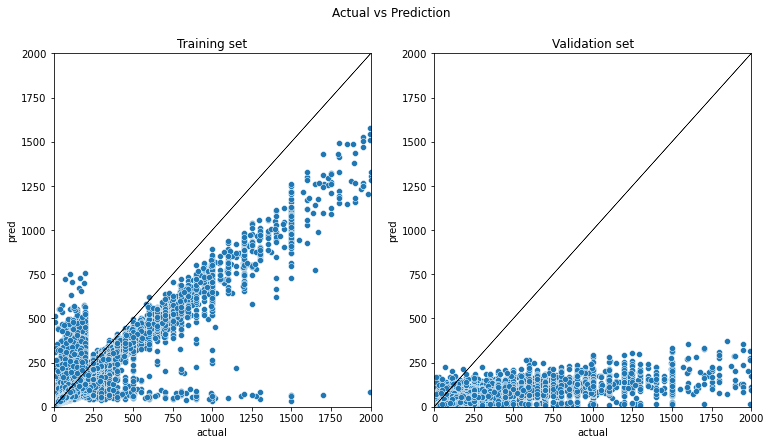

In [37]:
fig = plt.figure(figsize=(12.5, 6.5))
plt.suptitle('Actual vs Prediction')

plt.subplot(1, 2, 1)
ax = sns.scatterplot(pred_train['actual'], pred_train['pred'])
plt.plot(pred_train['actual'], pred_train['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_title('Training set');
# plt.axes().set_aspect('equal')
plt.subplot(1, 2, 2)
ax = sns.scatterplot(pred_valid['actual'], pred_valid['pred'])
plt.plot(pred_valid['actual'], pred_valid['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
plt.title('Validation set');

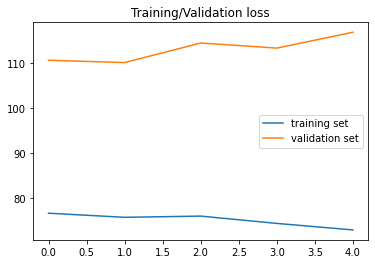

In [38]:
plt.plot(metrics['train_losses'], label='training set')
plt.plot(metrics['valid_losses'], label='validation set')
plt.title('Training/Validation loss')
plt.legend();

# Submission

In [39]:
pred_test_dfs = [pd.read_csv(os.path.join(output_dir, f'cv_fold{i + 1}_test.csv')) for i in range(N_SPLITS)]

In [40]:
pred_test = pd.concat(pred_test_dfs).groupby('id').sum()
pred_test = pred_test / N_SPLITS

In [41]:
pred_test.to_csv(os.path.join(output_dir, f'{EXPERIMENT}_submission.csv'), header=None)

# Visualization

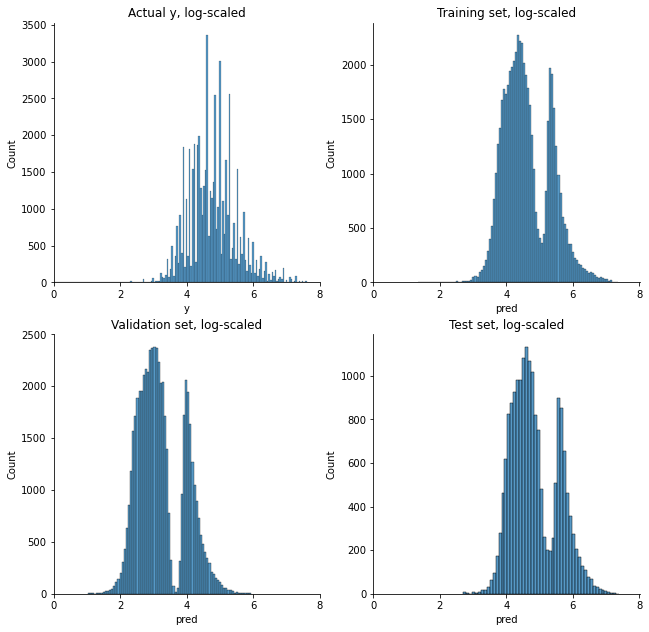

In [42]:
ylim_min, ylim_max = np.log(y_min * CLIP_LOWER_RATE), np.log(y_max * CLIP_UPPER_RATE)
fig = plt.figure(figsize=(10.5, 10.5))
plt.subplot(2, 2, 1)
ax = sns.histplot(y_log)
ax.set_title('Actual y, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 2)
ax = sns.histplot(np.log(pred_train['pred']))
ax.set_title('Training set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 3)
ax = sns.histplot(np.log(pred_valid['pred']))
ax.set_title('Validation set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 4)
ax = sns.histplot(np.log(pred_test['pred']))
ax.set_title('Test set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

fig.savefig(os.path.join(output_dir, 'figure.png'))

In [43]:
logger.debug('Complete({:.3f} seconds passed)'.format(time.time() - SINCE))

# Feature importance

In [44]:
pd.options.display.float_format = '{:.5f}'.format

In [45]:
models = []
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1

    ## モデルの保存
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'rb') as f:
        model = pickle.load(f)
    models.append(model)

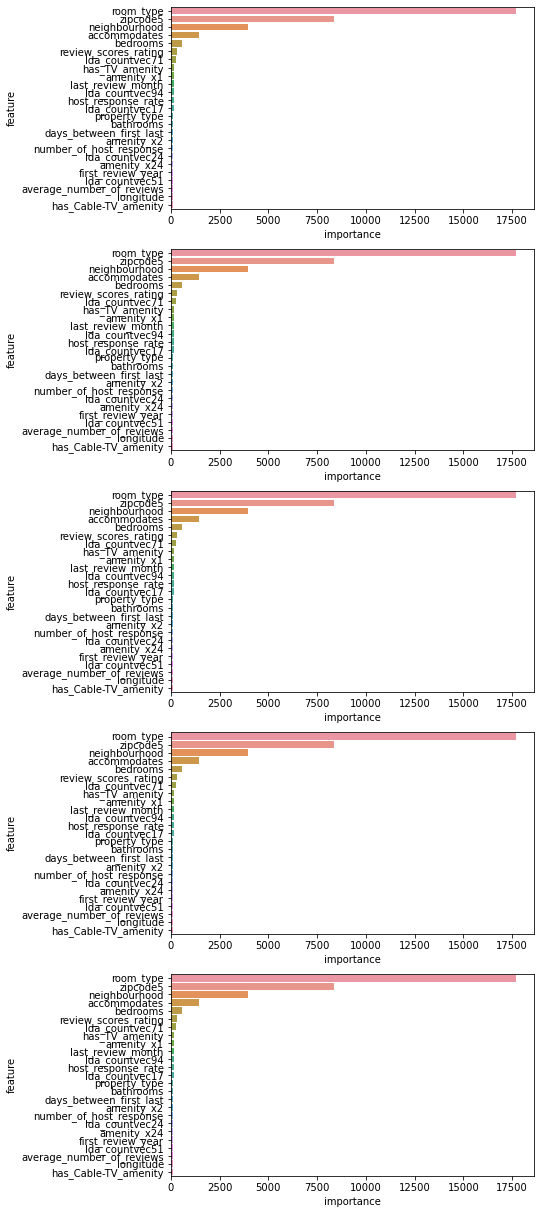

In [46]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model['class0'].feature_importances_, columns=['importance'])
    imp_df['feature'] = X_train.columns.tolist()
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance0.png'))

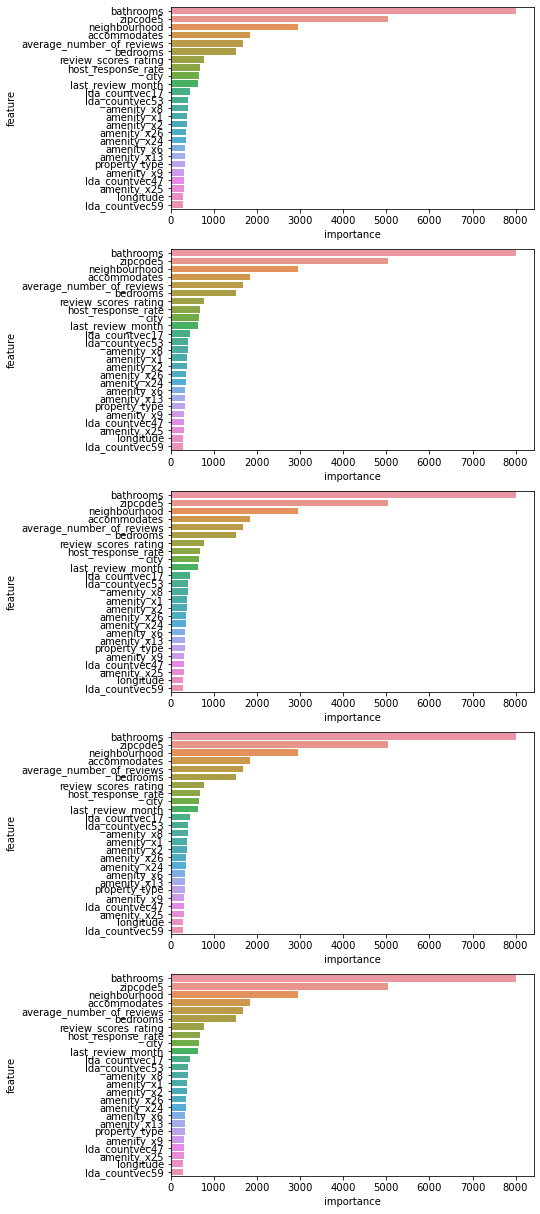

In [47]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model['class1'].feature_importances_, columns=['importance'])
    imp_df['feature'] = X_train.columns.tolist()
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance0.png'))

# Error

In [48]:
pred_valid = pd.read_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [49]:
pred_valid['diff'] = pred_valid['pred'] - pred_valid['actual']

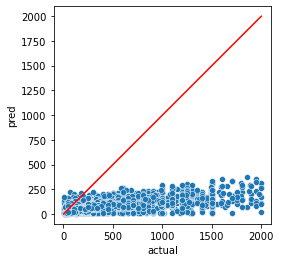

In [50]:
fig = plt.figure()
plt.axes().set_aspect('equal')
ax = sns.scatterplot(data=pred_valid, x='actual', y='pred')
ax = sns.lineplot(data=pred_valid, x='actual', y='actual', color='red')
fig.savefig(os.path.join(output_dir, 'compare_actual_prediction.png'))

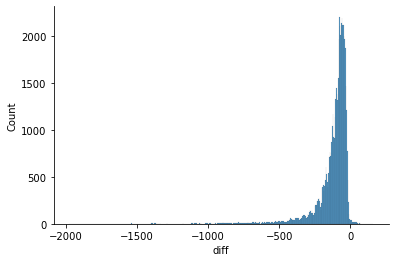

In [51]:
pred_valid.describe()
sns.histplot(data=pred_valid, x='diff')
sns.despine()

In [52]:
diff_df = pd.merge(X, pred_valid[['id', 'diff']]).set_index('id')

In [53]:
%%time
import sweetviz
report = sweetviz.analyze(diff_df, target_feat='diff', pairwise_analysis='off')
report.show_html(os.path.join(output_dir, ('sweetviz_error_report.html')))

                                             |                                             | [  0%]   00:00 ->…

Report C:\Users\nndropout\aiquest2021-assesment\experiments\05-15\sweetviz_error_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Wall time: 2min 11s


In [54]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = diff_df.shape[1]

In [55]:
diff_df.sort_values('diff').head(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [56]:
diff_df.sort_values('diff').tail(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [57]:
diff_df.corr()

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [58]:
diff_df.corr().sort_values('diff')['diff'].head(50)

accommodates                           -0.46945
bedrooms                               -0.44917
bathrooms                              -0.41653
beds                                   -0.39037
room_type                              -0.25192
lda_countvec17                         -0.24429
has_Familykid-friendly_amenity         -0.18339
has_Indoor-fireplace_amenity           -0.16327
has_TV_amenity                         -0.15496
has_Cable-TV_amenity                   -0.15045
lda_countvec92                         -0.13888
has_Dryer_amenity                      -0.13540
amenity_x1                             -0.13344
has_Washer_amenity                     -0.13233
has_Suitable-for-events_amenity        -0.13223
lda_countvec47                         -0.12418
amenity_x3                             -0.10866
has_thumbnail                          -0.10620
lda_countvec53                         -0.09759
lda_countvec71                         -0.09700
lda_countvec6                          -

In [59]:
from lightgbm import LGBMRegressor
estimator = LGBMRegressor(random_state=SEED, n_jobs=-1, importance_type='gain').fit(diff_df.drop(columns=['diff']), diff_df['diff'])

In [60]:
imp_df = pd.DataFrame(data=estimator.feature_importances_, columns=['importance'])

In [61]:
imp_df['feature'] = estimator.feature_name_

In [62]:
imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
imp_df

,importance,feature
3,950495809.89844,bedrooms
1,534656725.00000,bathrooms
0,496981354.00000,accommodates
18,230364260.60156,room_type
13,224278629.00000,longitude
...,...,...
95,0.00000,has_Air-conditioning_amenity
107,0.00000,has_Accessible-height-toilet_amenity
79,0.00000,has_Accessible-height-bed_amenity
103,0.00000,has_-smooth-pathway-to-front-door_amenity


In [63]:
imp_df.to_csv(os.path.join(output_dir, 'diff_feature_importances.csv'), index=False)